# Clasificación de partidas de ajedrez
En este notebook veremos distintas aproximaciones para estimar, dado un encuentro de jugadores de ajedrez, quien sería el ganador.

Por tanto pretendemos entrenar varios clasificadores. La mayoría de métodos y algoritmos de aprendizaje automático requieren de datos para entrenar o hacer funcionar al clasificador. En este caso, los datos que utilizaremos son los de la base de datos de [*Chess network dataset -- {KONECT}*](http://konect.uni-koblenz.de/networks/chess). El directorio descargado tiene la siguiente estructura:

---
```
Archivos: 
    meta.chess -- Metadata sobre la red
    out.chess -- La matriz de adjaciencia de la red en formato de valores separados, con un eje por linea
        La estructra de las columnas en el fichero out.chess es:
            Primera columna: ID del nodo origen 
            Segunda columna: ID del nodo destino
            Tercera columna: peso del eje
            Cuarta columna: timestamp del eje
```

---

Así, lo que tenemos en esta base de datos es lo siguiente. Tenemos un historial de 65053 partidas, repartidas a lo largo de cien meses consecutivos, entre enero de 1998 y abril de 2006. La primera columna del dataset indica el identificador único (ID) del jugador que jugó como blancas, y la segunda columna el ID del jugador que jugó como negras. El peso de la tercera columna indica si las blancas ganaron, si la partida quedó en tablas, o si las negras fueron las victoriosas. 

El dataset original fue creado para una competición de Kaggle, en la que se pretendía investigar en el ámbito de los sistemas de ELO. Normalmente, el ELO se utiliza como una medida matemática de la calidad de un jugador en un juego o deporte. Es ampliamente utilizada en juegos online, como el propio ajedrez, pero también en distintos juegos de habilidad o multijugador. 

Nuestro enfoque a este problema es completamente distinto. Podemos entender nuestro dataset como un grafo dinámico que muestra los resultados de distintos jugadores a lo largo del tiempo. Nosotros no crearemos una puntuación por jugador. En cambio, intentaremos predecir el resultado de una partida dada en función de un conjunto de características correspondientes a los dos nodos (jugadores) obtenidas en distintos periodos de tiempo precedentes al encuentro a predecir. 

Para esto primero hemos creado un script donde generamos unos datasets con las variables extraidas de cada nodo. Usando la libreía de [networkx](https://networkx.github.io/) generamos los grafos a traves del fichero *out.chess*. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import networkx as nx

Como explicamos en la memoria, existen distntas posibilidades para generar el corpus de entrenamiento, en función de cuantos meses queramos unificar, y cuantos grupos hacia atrás queramos mirar para realizar las predicciones. En el siguiente gráfico se muestran la cantidad de ejemplos conseguidos en función de estos dos parámetros.

![numero de ejemplos](examples.png "Número de ejemplos")

## Leer el corpus con el que queramos hacer los experimentos

En este apartado podemos elegir los parámetros t y k. t indica cuantos meses agrupar (en nuestro caso 12), y k cuantos grupos hacia atrás mirar (3 en nuestros experimentos). Todos los datasets están en formato arff para facilitar la lectura de los datos con otros softwares como Weka. Después de elegir estos parámetros se baraja una única vez el corpus para que todos los experimentos sean justos.

In [2]:
def readDataset(t,k):
    file_path = "datasets/dataset_t_"+str(t)+"_k_"+str(k)+".arff"
    dataset_x = []
    dataset_y = [] 
    with open(file_path, 'r') as f:
        data = False
        for line in f.read().splitlines():
            if not data and line == "@DATA":
                data = True
                continue
            if not data:
                continue
            dataset_x.append(tuple(map(float, line.split(",")[:-1])))
            dataset_y.append(line.split(",")[-1])
            
    return np.asarray(dataset_x), np.asarray(dataset_y)

In [3]:
t = 12
k = 3

dataset_x, dataset_y = readDataset(t, k)

p = np.random.permutation(dataset_y.shape[0])

dataset_x = dataset_x[p]
dataset_y = dataset_y[p]

## Generación de las componentes principales

Hemos probado los clasificadores tanto con las variables originales como con las 20 componentes más principales. En el siguiente código se generan estas componentes principales.

In [4]:
from sklearn import preprocessing

X_scaled = preprocessing.scale(dataset_x)

print(dataset_x.shape)
print(X_scaled.shape)

from sklearn.decomposition import PCA
pca = PCA(n_components=20, svd_solver='full')
pca.fit(X_scaled)
X_transformed = pca.transform(X_scaled)
print(X_transformed.shape)

(13352, 342)
(13352, 342)
(13352, 20)


## Predicción de múltiples clases

### Primer método

Nos referiremos al método directo (predecir una clase de las tres posibles) como el primer método. No se requiere ningún código adicional para predecir de esta forma.

### Segundo método

Con el segundo método nos referimos a la primera estrategia alternativa. Esta se basa en predecir primero si una partida acabó en tablas o no (ya que este problema está equilibradamente balanceado). Después, si se predice que el encuentro no ha finalizado en empate, se intenta adivinar quién fue el ganador.

In [5]:
class Talblas_Y_BlancasNegras:
    def __init__(self, model, *args, **kwargs):
        self.m_tabl = model(*args, **kwargs)
        self.m_bn = model(*args, **kwargs)
    def fit(self, x, y):
        x_tabl = x.copy()
        y_tabl = y.copy()
        y_tabl[y_tabl!='tablas'] = 'no-tabl'
        x_bn = x[y!='tablas']
        y_bn = y[y!='tablas']
        self.m_tabl.fit(x_tabl, y_tabl)
        self.m_bn.fit(x_bn, y_bn)
    def predict(self, x):
        predicted = self.m_tabl.predict(x)
        unclassified = predicted == 'no-tabl'
        if unclassified.any():
            predicted[unclassified] = self.m_bn.predict(x[unclassified])
        return predicted

### Tercer método

El tercer método consiste en predecir la clase más probable comparando cada clase con todas las demás, pero por parejas. La clase que más veces resulte vencedora será la elegida como predicción. En caso de empate, se predice la clase mayoritaria.

In [6]:
class Blancas_Tablas_Negras:
    def __init__(self, model, *args, **kwargs):
        self.m_tab_bla = model(*args, **kwargs)
        self.m_tab_neg = model(*args, **kwargs)
        self.m_bla_neg = model(*args, **kwargs)
    def fit(self, x, y):
        x_ = x[y!='negras']
        y_ = y[y!='negras']
        self.m_tab_bla.fit(x_, y_)
        x_ = x[y!='blancas']
        y_ = y[y!='blancas']
        self.m_tab_neg.fit(x_, y_)
        x_ = x[y!='tablas']
        y_ = y[y!='tablas']
        self.m_bla_neg.fit(x_, y_)
    def predict(self, x):
        pred_tab_bla = self.m_tab_bla.predict(x)
        pred_tab_neg = self.m_tab_neg.predict(x)
        pred_bla_neg = self.m_bla_neg.predict(x)
        
        predicted = pred_tab_bla.copy()
        predicted[:] = 'tablas'
        
        #predicted[pred_tab_bla == pred_tab_neg] = 'tablas'
        predicted[pred_tab_bla == pred_bla_neg] = 'blancas'
        predicted[pred_bla_neg == pred_tab_neg] = 'negras'
        
        return predicted

## Función para imprimir los gráficos

Imprime la medida de rendimiento de los clasificadores (el weighted empirical error en nuestro caso) por iteración de la validación cruzada, y muestra además la media. Se ordena la leyenda en función al rendimiento medio.


In [7]:
def comparingClf(clfs):
    clf_names = list(clfs)
    clf_names = sorted(clf_names, key=lambda name: mycv.mean(clfs[name]), reverse=True)
    
    colors = ["#377eb8", "#4daf4a", "#e41a1c", "#984ea3", "#ff7f00", "#ffff33", "#a65628", "#a65628", "#f781bf"]
    #colors = ["#a6cee3","#1f78b4","#b2df8a","#33a02c","#fb9a99","#e31a1c","#fdbf6f","#ff7f00","#cab2d6","#6a3d9a","#ffff99"]
    #colors = ["#9e0142","#d53e4f","#f46d43","#fdae61","#fee08b","#ffffbf","#e6f598","#abdda4","#66c2a5","#3288bd","#5e4fa2"]
    i = 0
    leg = []
    for clf_name in clf_names:
        l,=plt.plot(clfs[clf_name], color=colors[i%len(colors)], label=clf_name)
        plt.axhline(y=mycv.mean(clfs[clf_name]), linestyle='dashed', color=colors[i%len(colors)])
        leg.append(l)
        i+=1
    plt.ylabel('Weighted Empirical Error')
    plt.xlabel('CV Iteration')
    plt.legend(handles=leg,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

global_plots = {}

## Weighted empirical error

Como explicamos más detalladamente en el informe, hemos utilizado el weighted empirical error para comparar el rendimiento de los clasificadores y los métodos de clasificación multiclase.

$$\text{weighted empirical error} = \dfrac{\displaystyle{\sum_{i = 1}^{C} \frac{1}{p_i} \text{aciertos}(i)}}{C \cdot N}$$

In [8]:
class Weighted_empirical_error:
    def __init__(self, y):
        self.names = list(set([str(x) for x in y[:,]]))
        self.p_priori = self.names.copy()
        for i in range(len(self.p_priori)):
            self.p_priori[i] = 1 / (np.sum(y == self.p_priori[i]) / y.shape[0]) # 1/p_priori
    def calculate(self, pred_y, true_y):
        r = 0.0
        for i in range(len(self.names)):
            r += self.p_priori[i] * np.sum((pred_y == self.names[i])*(true_y == self.names[i]))
        return r/(pred_y.shape[0]*len(self.names))

### Probando el weighted empirical error

Hemos probado con varios clasificadores muy sencillos cuáles son los valores del weighted empirical error.

#### 100% de aciertos

Como podemos ver, si siempre acertamos, el weighted empirical error resulta 1.

In [9]:
num = int(dataset_y.shape[0]*0.7)
m = Weighted_empirical_error(dataset_y[num:,])
print("p_test:", 1/np.asarray(Weighted_empirical_error(dataset_y[num:,]).p_priori))

print(m.calculate(dataset_y[num:,],dataset_y[num:,]))

p_test: [ 0.1777334   0.52670994  0.29555667]
1.0


#### Clasificador aleatorio equiprobable

Si predecimos cualquiera de las tres clases con la misma probabilidad, el weighted empirical error valdrá alrededor de 0.33.

In [10]:
class White_Random:
    def fit(self, x,y):
        self.clases = list(set(y))
    def predict(self, x):
        c = np.random.choice(self.clases, x.shape[0])
        return c

In [11]:
clf = White_Random()

num = int(dataset_y.shape[0]*0.9)
m = Weighted_empirical_error(dataset_y[num:,])

clf.fit(X_transformed[:num,], dataset_y[:num,])
p = clf.predict(X_transformed[num:,])
print(m.calculate(p,dataset_y[num:,]))

0.335893548127


#### Clasificador aleatorio a partir de las probabilidades a priori

El weigthed empirical error también rondará el valor de 0.33 con cualquier predicción aleatorio. Abajo se muestra el ejemplo de predecir cada clase con su probabilidad a priori.

In [12]:
class Prob_Random:
    def fit(self,x,y, apriori = None):
        self.clases = list(set(y))
        if apriori == None:
            self.p_priori = self.clases.copy()
            for i in range(len(self.p_priori)):
                self.p_priori[i] = np.sum(y == self.p_priori[i]) / y.shape[0] # 1/p_priori
        else:
            self.p_priori = []
            self.clases = []
            for key in apriori:
                self.p_priori.append(apriori[key])
                self.clases.append(key) 
    def predict(self,x):
        c = np.random.choice(self.clases, x.shape[0], p=self.p_priori)
        return c

In [13]:
clf = Prob_Random()

num = int(dataset_y.shape[0]*0.9)
m = Weighted_empirical_error(dataset_y[num:,])

clf.fit(X_transformed[:num,], dataset_y[:num,])
#clf.fit(X_transformed[:num,], dataset_y[:num,], apriori={"negras": 1., "blancas": 0., "tablas": 0.})
print("p_clf:", np.asarray(clf.p_priori))
p = clf.predict(X_transformed[num:,])
print(m.calculate(p,dataset_y[num:,]))

p_clf: [ 0.18467044  0.52646471  0.28886485]
0.340877513396


## Cross validation

Este código permite realizar la validación cruzada de manera sencilla para todos los clasificadores.

In [14]:
from sklearn.model_selection import KFold

class MyCV:
    def __init__(self, x, y, num_cv=10):
        self.x = x
        self.y = y
        self.num_cv = num_cv    
        
    def set_X_Y(self,X,Y):
        self.x = X
        self.y = Y
    def setCV(cv):
        self.num_cv = cv
        
    def run(self, cls, print_=False, **kwargs):
        results = []
        kf = KFold(n_splits=self.num_cv, shuffle=True, random_state=1)
        i = 1
        for train, test in kf.split(self.x):
            m = Weighted_empirical_error(self.y[test])
            cls.fit(self.x[train], self.y[train], **kwargs)
            y_pred = cls.predict(self.x[test])
            r_tmp = m.calculate(y_pred,self.y[test])
            results.append(r_tmp)
            if (print_):
                print("Trained cv(%d): %f" % (i, r_tmp))
            i += 1
        return results
    
    def mean(self, r):
        re = 0
        for el in r:
            re+=el
        return re / len(r)

mycv = MyCV(dataset_x, dataset_y, num_cv=10)

## Comparación de los clasificadores y métodos de clasificación para múltiples clases

Ahora entrenaremos y realizaremos validaciones cruzadas para todos los clasificadores. También probaremos con las tres mencionadas técnicas de predicción multiclase.

### Naive Bayes

In [18]:
from sklearn.naive_bayes import GaussianNB
gnb_1 = GaussianNB()
gnb_2 = Talblas_Y_BlancasNegras(GaussianNB)
gnb_3 = Blancas_Tablas_Negras(GaussianNB)


mycv.set_X_Y(dataset_x, dataset_y)

r_g_1 = mycv.run(gnb_1)
r_g_2 = mycv.run(gnb_2)
r_g_3 = mycv.run(gnb_3)

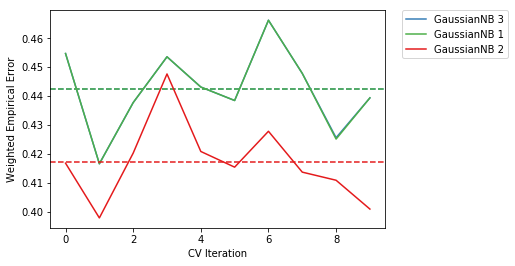

In [19]:
bayes_pl = {
    'GaussianNB 1': r_g_1,
    'GaussianNB 2': r_g_2,
    'GaussianNB 3': r_g_3
}
comparingClf(bayes_pl)

### Support Vector Machines


In [20]:
from sklearn.svm import SVC, NuSVC, LinearSVC

svc_1 = SVC()
svc_2 = Talblas_Y_BlancasNegras(SVC)
svc_3 = Blancas_Tablas_Negras(SVC)
 
nu_svc_1 = NuSVC()
nu_svc_2 = Talblas_Y_BlancasNegras(NuSVC)
nu_svc_3 = Blancas_Tablas_Negras(NuSVC)

linear_svc_1 = LinearSVC()
linear_svc_2 = Talblas_Y_BlancasNegras(LinearSVC)
linear_svc_3 = Blancas_Tablas_Negras(LinearSVC)

mycv.set_X_Y(X_transformed, dataset_y)

print("SVC:")
r_normal_1 = mycv.run(svc_1, print_=True)
r_normal_2 = mycv.run(svc_2, print_=True)
r_normal_3 = mycv.run(svc_3, print_=True)

print("\nNuSVC:")
r_nu_1 = mycv.run(nu_svc_1, print_=True)
r_nu_2 = mycv.run(nu_svc_2, print_=True)
r_nu_3 = mycv.run(nu_svc_3, print_=True)

print("\nLinearSVC:")
r_linear_1 = mycv.run(linear_svc_1, print_=True)
r_linear_2 = mycv.run(linear_svc_2, print_=True)
r_linear_3 = mycv.run(linear_svc_3, print_=True)

SVC:
Trained cv(1): 0.368494
Trained cv(2): 0.344722
Trained cv(3): 0.356463
Trained cv(4): 0.358586
Trained cv(5): 0.346951
Trained cv(6): 0.354407
Trained cv(7): 0.352246
Trained cv(8): 0.361112
Trained cv(9): 0.365062
Trained cv(10): 0.356895
Trained cv(1): 0.402458
Trained cv(2): 0.390499
Trained cv(3): 0.389605
Trained cv(4): 0.378055
Trained cv(5): 0.377653
Trained cv(6): 0.390804
Trained cv(7): 0.401230
Trained cv(8): 0.373700
Trained cv(9): 0.366876
Trained cv(10): 0.398264
Trained cv(1): 0.368494
Trained cv(2): 0.344722
Trained cv(3): 0.355646
Trained cv(4): 0.358586
Trained cv(5): 0.346951
Trained cv(6): 0.354407
Trained cv(7): 0.352701
Trained cv(8): 0.361571
Trained cv(9): 0.365062
Trained cv(10): 0.356895

NuSVC:
Trained cv(1): 0.384252
Trained cv(2): 0.359963
Trained cv(3): 0.365238
Trained cv(4): 0.369120
Trained cv(5): 0.361461
Trained cv(6): 0.359110
Trained cv(7): 0.361676
Trained cv(8): 0.370866
Trained cv(9): 0.362075
Trained cv(10): 0.367075
Trained cv(1): 0.403436

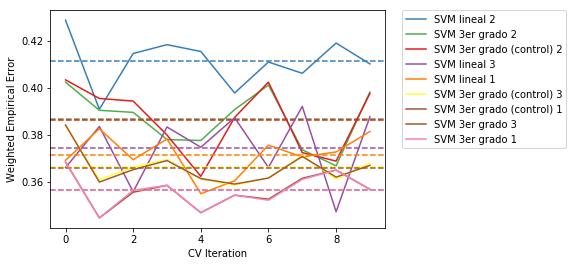

In [21]:
svm_pl = {
    'SVM 3er grado 1': r_normal_1,
    'SVM 3er grado 2': r_normal_2,
    'SVM 3er grado 3': r_normal_3,

    'SVM 3er grado (control) 1': r_nu_1,
    'SVM 3er grado (control) 2': r_nu_2,
    'SVM 3er grado (control) 3': r_nu_3,

    'SVM lineal 1': r_linear_1,
    'SVM lineal 2': r_linear_2,
    'SVM lineal 3': r_linear_3
}
comparingClf(svm_pl)

### K-Nearest Neighbors

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import DistanceMetric

distances = ['euclidean', 'manhattan', 'chebyshev']
ks = [k for k in range(1,10,2)]

mycv.set_X_Y(X_transformed, dataset_y)

em = np.zeros((len(distances), len(ks), 3, mycv.num_cv))


for dis_i in range(len(distances)):
    for k_i in range(len(ks)):
        k_NN_1 = KNeighborsClassifier(n_neighbors=ks[k_i], algorithm='ball_tree', metric=distances[dis_i], n_jobs=-1)
        k_NN_2 = Talblas_Y_BlancasNegras(KNeighborsClassifier, n_neighbors=ks[k_i], algorithm='ball_tree', metric=distances[dis_i], n_jobs=-1)
        k_NN_3 = Blancas_Tablas_Negras(KNeighborsClassifier, n_neighbors=ks[k_i], algorithm='ball_tree', metric=distances[dis_i], n_jobs=-1)

        r_1 = mycv.run(k_NN_1)
        r_2 = mycv.run(k_NN_2)
        r_3 = mycv.run(k_NN_3)
        
        em[dis_i, k_i, 0] = np.asarray(r_1)
        em[dis_i, k_i, 1] = np.asarray(r_2)
        em[dis_i, k_i, 2] = np.asarray(r_3)

        print(distances[dis_i], "|", "k:", ks[k_i], ":", mycv.mean(em[dis_i, k_i,:,:].T))
        

euclidean | k: 1 : [ 0.39401539  0.395211    0.3956362 ]
euclidean | k: 3 : [ 0.38646606  0.3890237   0.3861301 ]
euclidean | k: 5 : [ 0.39564336  0.40297645  0.39230645]
euclidean | k: 7 : [ 0.39863341  0.40224362  0.38880506]
euclidean | k: 9 : [ 0.39406236  0.40167143  0.38850131]
manhattan | k: 1 : [ 0.38896446  0.39024217  0.39078164]
manhattan | k: 3 : [ 0.37555377  0.38444468  0.37933228]
manhattan | k: 5 : [ 0.39039849  0.3944913   0.38931988]
manhattan | k: 7 : [ 0.3940776   0.39442022  0.38659478]
manhattan | k: 9 : [ 0.39091238  0.39799846  0.38320967]
chebyshev | k: 1 : [ 0.39498164  0.39632025  0.39665216]
chebyshev | k: 3 : [ 0.37797356  0.38674017  0.3834918 ]
chebyshev | k: 5 : [ 0.3924597   0.39039581  0.38633221]
chebyshev | k: 7 : [ 0.38887655  0.39111405  0.38262298]
chebyshev | k: 9 : [ 0.38157752  0.3919136   0.37652124]


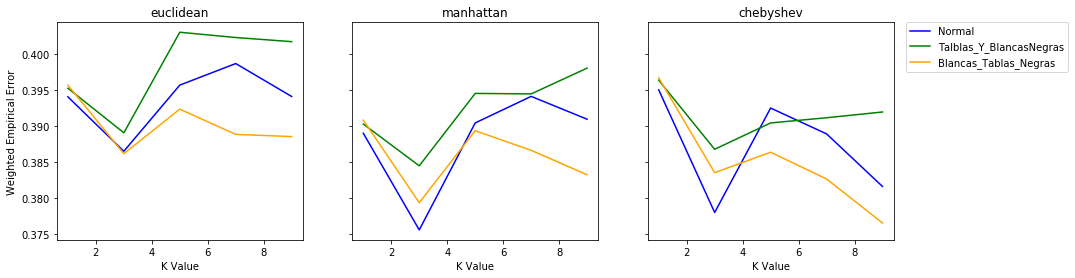

Best Normal:
Dist: euclidean 	| k: 7 	= [ 0.4112048   0.41376241  0.39068346  0.40461467  0.39890577  0.38551487
  0.38992645  0.40735772  0.37422967  0.41013429]
Best Talblas_Y_BlancasNegras:
Dist: euclidean 	| k: 5 	= [ 0.43004398  0.39365047  0.41032722  0.41402455  0.39798085  0.3869761
  0.40522469  0.39898715  0.383866    0.40868352]
Best Blancas_Tablas_Negras:
Dist: chebyshev 	| k: 1 	= [ 0.40391842  0.38890012  0.41318305  0.39301318  0.37157402  0.40996266
  0.3880819   0.40232304  0.39011674  0.40544842]


In [23]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(15,4))

means = np.mean(em, -1)

ax1.set_title('euclidean')

euclidean_l,=ax1.plot(ks, means[0,:,0], color="blue", label='Normal')
manhattan_l,=ax1.plot(ks, means[0,:,1], color="green", label='Talblas_Y_BlancasNegras')
chebyshev_l,=ax1.plot(ks, means[0,:,2], color="orange", label='Blancas_Tablas_Negras')
ax1.set_ylabel('Weighted Empirical Error')
ax1.set_xlabel('K Value')


ax2.set_title('manhattan')

euclidean_l,=ax2.plot(ks, means[1,:,0], color="blue", label='Normal')
manhattan_l,=ax2.plot(ks, means[1,:,1], color="green", label='Talblas_Y_BlancasNegras')
chebyshev_l,=ax2.plot(ks, means[1,:,2], color="orange", label='Blancas_Tablas_Negras')
ax2.set_xlabel('K Value')

ax3.set_title('chebyshev')
euclidean_l_,=ax3.plot(ks, means[2,:,0], color="blue", label='Normal')
manhattan_l_,=ax3.plot(ks, means[2,:,1], color="green", label='Talblas_Y_BlancasNegras')
chebyshev_l_,=ax3.plot(ks, means[2,:,2], color="orange", label='Blancas_Tablas_Negras')
ax3.set_xlabel('K Value')
ax3.legend(handles=[euclidean_l_, manhattan_l_, chebyshev_l_],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

dist_1, k_1 = np.where(means[:,:,0]==means[:,:,0].max())
dist_2, k_2 = np.where(means[:,:,1]==means[:,:,1].max())
dist_3, k_3 = np.where(means[:,:,2]==means[:,:,2].max())

best_k_means_1 = em[dist_1[0], k_1[0], 0, :]
best_k_means_2 = em[dist_2[0], k_2[0], 1, :]
best_k_means_3 = em[dist_3[0], k_3[0], 2, :]

print("Best Normal:")
print("Dist:", distances[dist_1[0]], "\t| k:", ks[k_1[0]], "\t=", best_k_means_1)
print("Best Talblas_Y_BlancasNegras:")
print("Dist:", distances[dist_2[0]], "\t| k:", ks[k_2[0]], "\t=", best_k_means_2)
print("Best Blancas_Tablas_Negras:")
print("Dist:", distances[dist_3[0]], "\t| k:", ks[k_3[0]], "\t=", best_k_means_3)

k_mean_pl = {
    'kNN ('+distances[dist_1[0]]+' | k='+str(ks[k_1[0]])+') 1': best_k_means_1,
    'kNN ('+distances[dist_2[0]]+' | k='+str(ks[k_2[0]])+') 2': best_k_means_2,
    'kNN ('+distances[dist_3[0]]+' | k='+str(ks[k_3[0]])+') 3': best_k_means_3,
}

### Decision Trees

In [24]:
from sklearn.tree import DecisionTreeClassifier

mycv.set_X_Y(dataset_x, dataset_y)

clf_tree_1 = DecisionTreeClassifier(max_features='auto')
clf_tree_2 = Talblas_Y_BlancasNegras(DecisionTreeClassifier,max_features='auto')
clf_tree_3 = Blancas_Tablas_Negras(DecisionTreeClassifier, max_features='auto')

r_tree_1 = mycv.run(clf_tree_1)
r_tree_2 = mycv.run(clf_tree_2)
r_tree_3 = mycv.run(clf_tree_3)

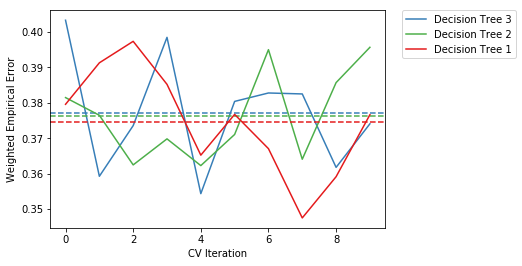

In [25]:
tree_pl = {
    'Decision Tree 1': r_tree_1,
    'Decision Tree 2': r_tree_2,
    'Decision Tree 3': r_tree_3,

}
comparingClf(tree_pl)

### Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

mycv.set_X_Y(dataset_x, dataset_y)

rf_gini_1 = RandomForestClassifier(n_estimators=11, criterion="gini", n_jobs=-1)
rf_gini_2 = Talblas_Y_BlancasNegras(RandomForestClassifier, n_estimators=11, criterion="gini", n_jobs=-1)
rf_gini_3 = Blancas_Tablas_Negras(RandomForestClassifier, n_estimators=11, criterion="gini", n_jobs=-1)

rf_entropy_1 = RandomForestClassifier(n_estimators=11, criterion="entropy", n_jobs=-1)
rf_entropy_2 = Talblas_Y_BlancasNegras(RandomForestClassifier, n_estimators=11, criterion="entropy", n_jobs=-1)
rf_entropy_3 = Blancas_Tablas_Negras(RandomForestClassifier, n_estimators=11, criterion="entropy", n_jobs=-1)

r_gini_1 = mycv.run(rf_gini_1)
r_gini_2 = mycv.run(rf_gini_2)
r_gini_3 = mycv.run(rf_gini_3)

r_entropy_1 = mycv.run(rf_entropy_1)
r_entropy_2 = mycv.run(rf_entropy_2)
r_entropy_3 = mycv.run(rf_entropy_3)

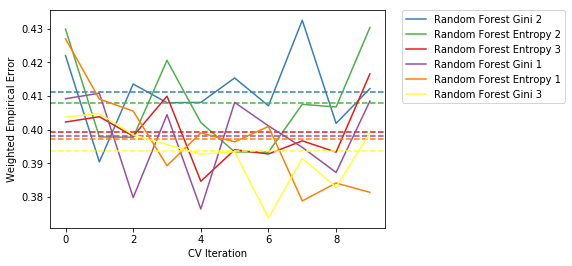

In [27]:
forest_pl = {
    'Random Forest Gini 1': r_gini_1,
    'Random Forest Gini 2': r_gini_2,
    'Random Forest Gini 3': r_gini_3,

    'Random Forest Entropy 1': r_entropy_1,
    'Random Forest Entropy 2': r_entropy_2,
    'Random Forest Entropy 3': r_entropy_3,

}
comparingClf(forest_pl)

### Extreme Learning Machine

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, RMSprop, Adadelta
from keras import backend as K

class DNN_funcs:
    def __init__(self, prob = False):
        self.classes = None
        self.prob = prob
        if self.prob:
            self.ps = None
    def encode(self, Ys):
        if not self.classes:
            self.classes = list(set(Ys))
            if self.prob:
                self.ps = [.0]*len(self.classes)
                for i in range(len(self.classes)):
                    self.ps[i] = np.sum(Ys==self.classes[i])/Ys.shape[0]
        tmp = np.zeros((Ys.shape[0],len(self.classes)))
        def change(x):
            a = [0]*len(self.classes)
            a[self.classes.index(x)] = 1
            return a
        for i in range(tmp.shape[0]):
            tmp[i] = change(Ys[i])
        return tmp
    def decode(self, pYs):
        tmp = np.empty(pYs.shape[0], dtype=object)
        def change(y):
            if not self.prob:
                return self.classes[np.argmax(y)]
            else:
                return self.classes[np.argmax(y/np.asarray(self.ps))]
        for i in range(tmp.shape[0]):
            tmp[i] = change(pYs[i])
        return tmp

Using TensorFlow backend.


In [31]:
class MyELM(DNN_funcs):
    def __init__(self, prob=False):
        DNN_funcs.__init__(self, prob)
    def fit(self, x, y):
        DNN_funcs.__init__(self, self.prob)
        self.batch_size = 16
        self.nb_epochs = 10
        lr = 0.07
        dec = 0.01
        mom = 0.9

        num = len(list(set(y)))

        self.model_ = Sequential()
        self.model_.add(Dense(256, input_shape=x.shape[1:]))
        self.model_.add(Activation('sigmoid'))

        self.model_.add(Dense(256))
        self.model_.add(Activation('sigmoid'))
        #self.model_.compile()
        
        self.model = Sequential()
        self.model.add(Dense(num, input_shape=(256,)))
        self.model.add(Activation('softmax'))

        sgd = SGD(lr=lr, decay=dec, momentum=mom)
        aladelta = Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)

        self.model.compile(loss='categorical_crossentropy', optimizer=aladelta)
        self.model.fit(self.model_.predict(x), self.encode(y), batch_size=self.batch_size, nb_epoch=self.nb_epochs, verbose=0)
    
    def predict(self,x):
        return self.decode(self.model.predict(self.model_.predict(x)))

In [30]:
mycv.set_X_Y(dataset_x, dataset_y)

elm_n_1 = MyELM(prob=False)
elm_n_2 = Talblas_Y_BlancasNegras(MyELM, prob=False)
elm_n_3 = Blancas_Tablas_Negras(MyELM, prob=False)

print("ELM 1")
r_elm_n_1 = mycv.run(elm_n_1)
print("ELM 2")
r_elm_n_2 = mycv.run(elm_n_2)
print("ELM 3")
r_elm_n_3 = mycv.run(elm_n_3)

elm_p_1 = MyELM(prob=True)
elm_p_2 = Talblas_Y_BlancasNegras(MyELM, prob=True)
elm_p_3 = Blancas_Tablas_Negras(MyELM, prob=True)

print("ELM (salida normalizada) 1")
r_elm_p_1 = mycv.run(elm_p_1)
print("ELM (salida normalizada) 2")
r_elm_p_2 = mycv.run(elm_p_2)
print("ELM (salida normalizada) 3")
r_elm_p_3 = mycv.run(elm_p_3)

ELM 1
ELM 2
ELM 3
ELM (salida normalizada) 1
ELM (salida normalizada) 2
ELM (salida normalizada) 3


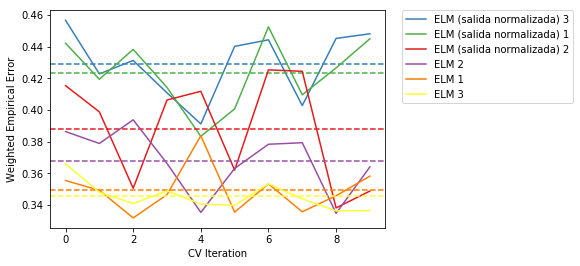

In [32]:
elm_pl = {
    'ELM 1': r_elm_n_1,
    'ELM 2': r_elm_n_2,
    'ELM 3': r_elm_n_3,

    'ELM (salida normalizada) 1': r_elm_p_1,
    'ELM (salida normalizada) 2': r_elm_p_2,
    'ELM (salida normalizada) 3': r_elm_p_3
}

comparingClf(elm_pl)

### Feedforward Neural Network

In [33]:
class MyFNN(DNN_funcs):
    def __init__(self, prob=False):
        DNN_funcs.__init__(self, prob)
    def fit(self, x, y):
        DNN_funcs.__init__(self, self.prob)
        
        self.batch_size = 16
        self.nb_epochs = 10
        lr = 0.07
        dec = 0.01
        mom = 0.9

        num = len(list(set(y)))

        self.model = Sequential()
        self.model.add(Dense(256, input_shape=x.shape[1:]))
        self.model.add(Activation('sigmoid'))

        self.model.add(Dense(256))
        self.model.add(Activation('sigmoid'))
        
        self.model.add(Dense(num))
        self.model.add(Activation('softmax'))

        sgd = SGD(lr=lr, decay=dec, momentum=mom)
        aladelta = Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)

        self.model.compile(loss='categorical_crossentropy', optimizer=aladelta)
        self.model.fit(x, self.encode(y), batch_size=self.batch_size, nb_epoch=self.nb_epochs, verbose=0)
    
    def predict(self,x):
        return self.decode(self.model.predict(x))

In [34]:
mycv.set_X_Y(dataset_x, dataset_y)

fnn_n_1 = MyFNN(prob=False)
fnn_n_2 = Talblas_Y_BlancasNegras(MyFNN, prob=False)
fnn_n_3 = Blancas_Tablas_Negras(MyFNN, prob=False)

print("FNN 1")
r_fnn_n_1 = mycv.run(elm_n_1)
print("FNN 2")
r_fnn_n_2 = mycv.run(elm_n_2)
print("FNN 3")
r_fnn_n_3 = mycv.run(elm_n_3)


fnn_p_1 = MyFNN(prob=True)
fnn_p_2 = Talblas_Y_BlancasNegras(MyFNN, prob=True)
fnn_p_3 = Blancas_Tablas_Negras(MyFNN, prob=True)

print("FNN (salida normalizada) 1")
r_fnn_p_1 = mycv.run(elm_p_1)
print("FNN (salida normalizada) 2")
r_fnn_p_2 = mycv.run(elm_p_2)
print("FNN (salida normalizada) 3")
r_fnn_p_3 = mycv.run(elm_p_3)

FNN 1
FNN 2
FNN 3
FNN (salida normalizada) 1
FNN (salida normalizada) 2
FNN (salida normalizada) 3


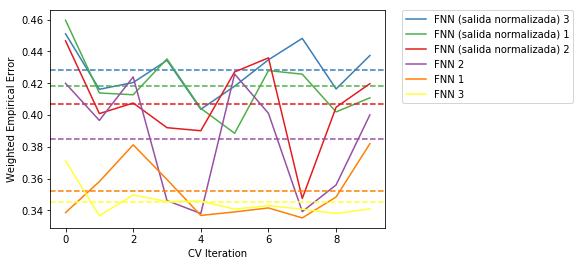

In [35]:
fnn_pl = {
    'FNN 1': r_fnn_n_1,
    'FNN 2': r_fnn_n_2,
    'FNN 3': r_fnn_n_3,

    'FNN (salida normalizada) 1': r_fnn_p_1,
    'FNN (salida normalizada) 2': r_fnn_p_2,
    'FNN (salida normalizada) 3': r_fnn_p_3
}

comparingClf(fnn_pl)

## Imprimir los resultados para todos los clasificadores

A continuación se muestran los resultados de los clasificadores entrenados (para el kNN solo se muestra el mejor caso). Se han separado los clasificadores por el método de predicción multiclase.

In [36]:
global_plots.update(bayes_pl)
global_plots.update(svm_pl)
global_plots.update(k_mean_pl)
global_plots.update(tree_pl)
global_plots.update(forest_pl)
global_plots.update(elm_pl)
global_plots.update(fnn_pl)

In [37]:
method_1 = {}
method_2 = {}
method_3 = {}
for m in global_plots.keys():
    if m[-1]=='1':
        method_1[m] = global_plots[m]
    elif m[-1]=='2':
        method_2[m] = global_plots[m]
    else:
        method_3[m] = global_plots[m]

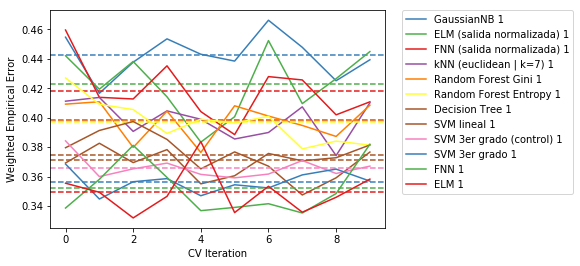

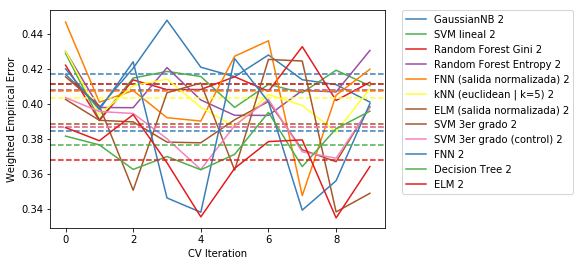

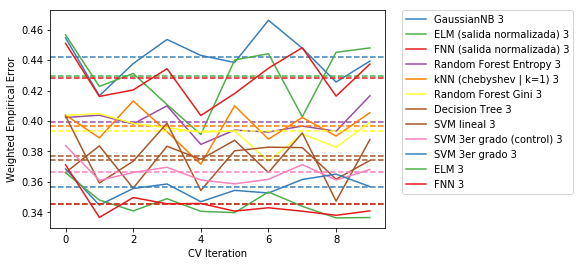

In [38]:
comparingClf(method_1)
comparingClf(method_2)
comparingClf(method_3)